<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/DL-SatelliteImagery/Satellite_Imagery_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
# !pip install patchify

In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [3]:
minmaxscaler = MinMaxScaler()

In [4]:
# !ls -lah '/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset'

In [5]:
dataset_root_folder = "./Semantic segmentation dataset/"

In [6]:
dataset_name = "DubaiDataset"
print(os.path.join(dataset_root_folder))

./Semantic segmentation dataset/


In [7]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder)):
    dir_name = path.split(os.path.sep)[-1]
    # print(dir_name)
    if dir_name == "masks":  # 'images
        images = os.listdir(path)
        print(path)
        # print(images)
        for i, image_name in enumerate(images):
            if image_name.endswith(".png"):  # '.jpg
                # print(image_name)
                a = True

./Semantic segmentation dataset/Tile 1\masks
./Semantic segmentation dataset/Tile 2\masks
./Semantic segmentation dataset/Tile 3\masks
./Semantic segmentation dataset/Tile 4\masks
./Semantic segmentation dataset/Tile 5\masks
./Semantic segmentation dataset/Tile 6\masks
./Semantic segmentation dataset/Tile 7\masks
./Semantic segmentation dataset/Tile 8\masks


In [8]:
image_patch_size = 256

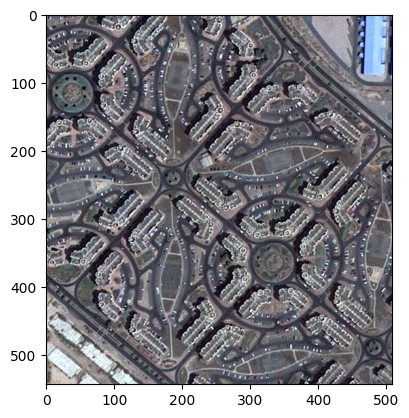

In [9]:
# Read the image
image = cv2.imread(f"{dataset_root_folder}/Tile 2/images/image_part_001.jpg", 1)
plt.imshow(image)

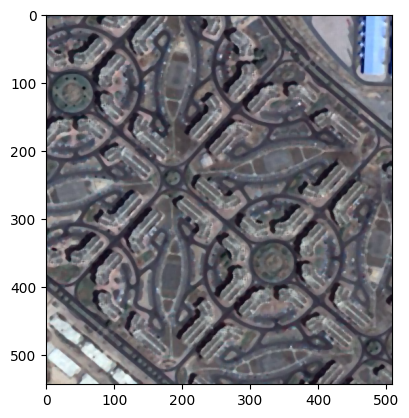

In [10]:
# Apply median blur
filtered_image = cv2.medianBlur(image, 5)

# Display the image
plt.imshow(filtered_image)

In [11]:
image.shape

(544, 509, 3)

In [12]:
image_patches = patchify(
    image, (image_patch_size, image_patch_size, 3), step=image_patch_size
)

In [13]:
len(image_patches)

2

In [14]:
print(image_patches.shape)

(2, 1, 1, 256, 256, 3)


In [15]:
minmaxscaler = MinMaxScaler()

In [16]:
image_x = image_patches[0, 0, :, :]
# MinMaxScaler
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(
    image_x.shape
)

In [17]:
image_y[0].shape

(256, 256, 3)

In [18]:
print(type(image))

<class 'numpy.ndarray'>


In [19]:
type(Image.fromarray(image))

PIL.Image.Image

In [20]:
image.shape

(544, 509, 3)

In [21]:
(image.shape[0] // image_patch_size) * image_patch_size

512

In [22]:
image_dataset = []
mask_dataset = []

for image_type in ["images", "masks"]:
    if image_type == "images":
        image_extension = "jpg"
    elif image_type == "masks":
        image_extension = "png"
    for tile_id in range(1, 8):
        for image_id in range(1, 20):
            image = cv2.imread(
                f"{dataset_root_folder}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}",
                1,
            )
            if image is not None:
                if image_type == "masks":
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # print(image.shape)
                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size
                # print("{} --- {} - {}".format(image.shape, size_x, size_y))
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))
                # print("({},  {})".format(image.size[0],image.size[1]))
                image = np.array(image)
                patched_images = patchify(
                    image,
                    (image_patch_size, image_patch_size, 3),
                    step=image_patch_size,
                )
                # print(len(patched_images))
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == "images":
                            individual_patched_image = patched_images[i, j, :, :]
                            # print(individual_patched_image.shape)
                            individual_patched_image = minmaxscaler.fit_transform(
                                individual_patched_image.reshape(
                                    -1, individual_patched_image.shape[-1]
                                )
                            ).reshape(individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            # print(individual_patched_image.shape)
                            image_dataset.append(individual_patched_image)
                        elif image_type == "masks":
                            individual_patched_mask = patched_images[i, j, :, :]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

In [23]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [24]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [25]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [26]:
type(image_dataset[0])

numpy.ndarray

In [27]:
type(np.reshape(image_dataset[0], (image_patch_size, image_patch_size, 3)))

numpy.ndarray

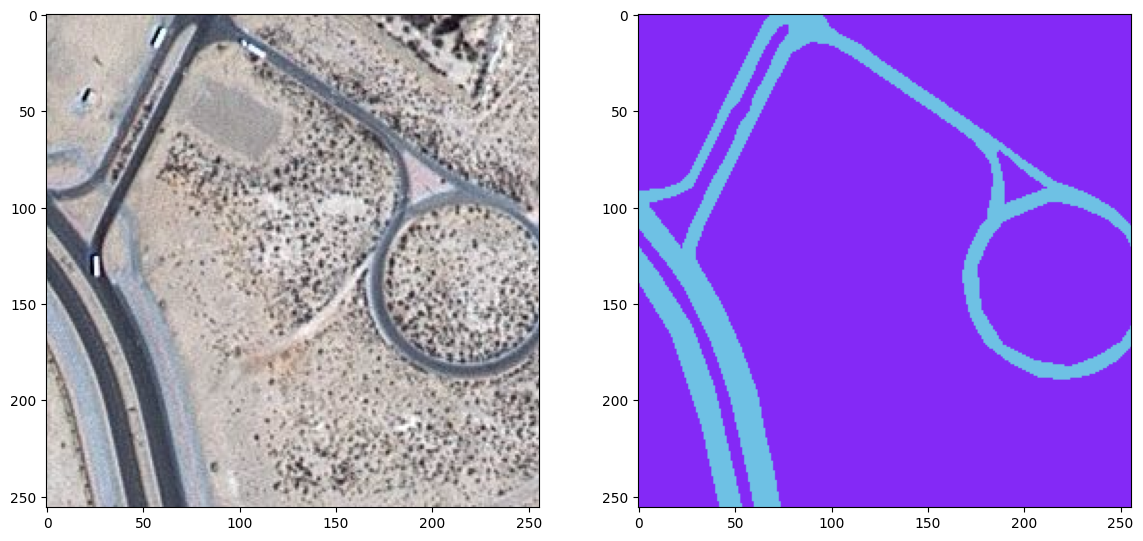

In [28]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

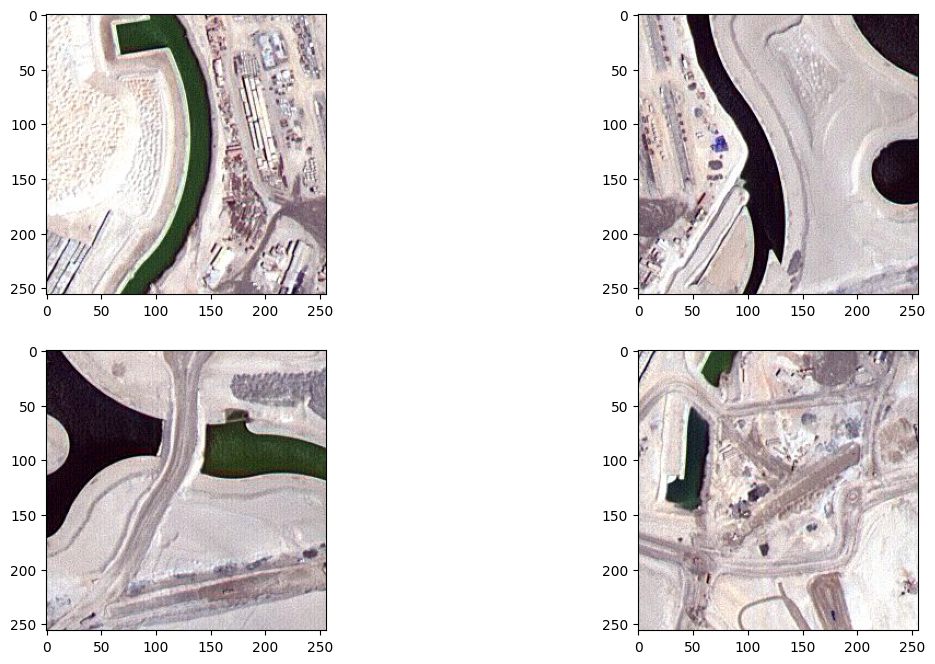

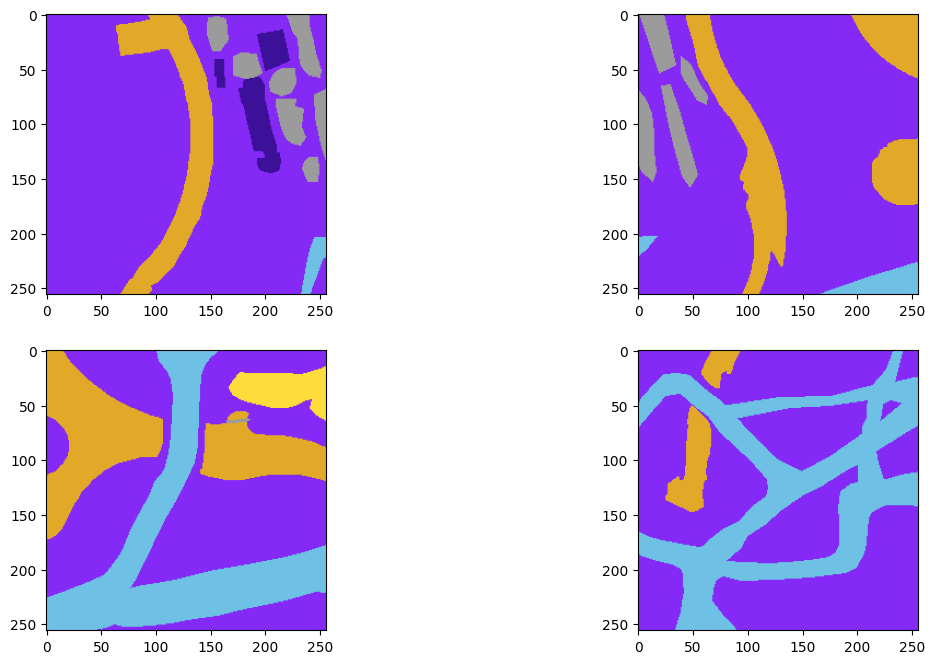

In [29]:
plt.figure(figsize=(14, 8))

# Display the first four images from image_dataset
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image_dataset[i])

plt.show()

plt.figure(figsize=(14, 8))

# Display the first four images from mask_dataset
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(mask_dataset[i])

plt.show()

In [30]:
class_building = "#3C1098"
class_building = class_building.lstrip("#")
class_building = np.array(tuple(int(class_building[i : i + 2], 16) for i in (0, 2, 4)))
print(class_building)

class_land = "#8429F6"
class_land = class_land.lstrip("#")
class_land = np.array(tuple(int(class_land[i : i + 2], 16) for i in (0, 2, 4)))
print(class_land)

class_road = "#6EC1E4"
class_road = class_road.lstrip("#")
class_road = np.array(tuple(int(class_road[i : i + 2], 16) for i in (0, 2, 4)))
print(class_road)

class_vegetation = "#FEDD3A"
class_vegetation = class_vegetation.lstrip("#")
class_vegetation = np.array(
    tuple(int(class_vegetation[i : i + 2], 16) for i in (0, 2, 4))
)
print(class_vegetation)

class_water = "#E2A929"
class_water = class_water.lstrip("#")
class_water = np.array(tuple(int(class_water[i : i + 2], 16) for i in (0, 2, 4)))
print(class_water)

class_unlabeled = "#9B9B9B"
class_unlabeled = class_unlabeled.lstrip("#")
class_unlabeled = np.array(
    tuple(int(class_unlabeled[i : i + 2], 16) for i in (0, 2, 4))
)
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [31]:
mask_dataset.shape[0]

945

In [32]:
label = individual_patched_mask

In [33]:
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
    # print(label_segment)
    label_segment = label_segment[:, :, 0]
    # print(label_segment)
    return label_segment

In [34]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

In [35]:
print(len(labels))

945


In [36]:
labels = np.array(labels)

In [37]:
labels[3]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [38]:
labels = np.expand_dims(labels, axis=3)

In [39]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [40]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [41]:
print("Total unique labels based on masks: ", format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


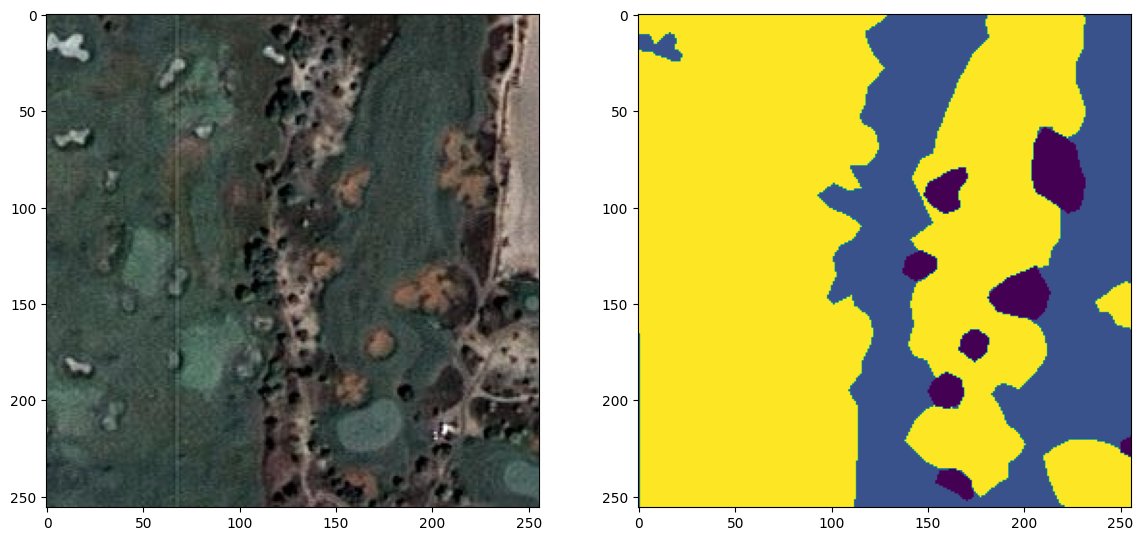

In [42]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
# plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:, :, 0])

In [43]:
labels[0][:, :, 0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [44]:
total_classes = len(np.unique(labels))

In [45]:
total_classes

6

In [46]:
from tensorflow.keras.utils import to_categorical

In [47]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [48]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [49]:
master_training_dataset = image_dataset
print(master_training_dataset.shape)

(945, 256, 256, 3)


In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    master_training_dataset,
    labels_categorical_dataset,
    test_size=0.15,
    random_state=100,
)

In [52]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [53]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [54]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6
